<a href="https://colab.research.google.com/github/24KN5A/E-Commerce-Insights-RFM-Churn-Analysis-/blob/main/E-commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [ ]:
df = pd.read_csv('/content/data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str}, on_bad_lines='skip')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021239 entries, 0 to 1021238
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   InvoiceNo    1021239 non-null  object
 1   StockCode    1021237 non-null  object
 2   Description  1018492 non-null  object
 3   Quantity     1021233 non-null  object
 4   InvoiceDate  1021226 non-null  object
 5   UnitPrice    1021225 non-null  object
 6   CustomerID   775125 non-null   object
 7   Country      1021212 non-null  object
dtypes: object(8)
memory usage: 62.3+ MB


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,2
Description,2747
Quantity,6
InvoiceDate,13
UnitPrice,14
CustomerID,246114
Country,27


In [ ]:
df = df.dropna(subset=['Description'])
df = df.dropna(subset=['CustomerID'])

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,1
InvoiceDate,0
UnitPrice,1
CustomerID,0
Country,3


In [ ]:
df.duplicated().sum()
df = df.drop_duplicates()
df['CustomerID'] = df['CustomerID'].astype(str)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
(df['Quantity'] <= 0).sum(), (df['UnitPrice'] <= 0).sum()

(np.int64(14345), np.int64(57))

In [ ]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637106 entries, 0 to 1021238
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    637106 non-null  object 
 1   StockCode    637106 non-null  object 
 2   Description  637106 non-null  object 
 3   Quantity     637106 non-null  float64
 4   InvoiceDate  637106 non-null  object 
 5   UnitPrice    637106 non-null  float64
 6   CustomerID   637106 non-null  object 
 7   Country      637106 non-null  object 
dtypes: float64(2), object(6)
memory usage: 43.7+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice
count,637106.000000,637106.000000
mean,13.091542,3.157455
std,176.366014,24.155307
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom


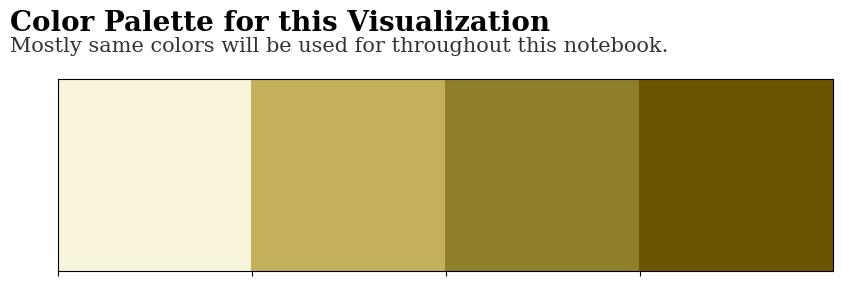

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']
palette = sns.color_palette(palette=colors)

sns.palplot(palette, size=2.5)
plt.text(-0.75, -0.75, 'Color Palette for this Visualization', {'font': 'serif', 'size': 20, 'weight': 'bold'})
plt.text(-0.75, -0.64, 'Mostly same colors will be used for throughout this notebook.', {'font': 'serif', 'size': 15, 'weight': 'normal'}, alpha=0.8)
plt.show()

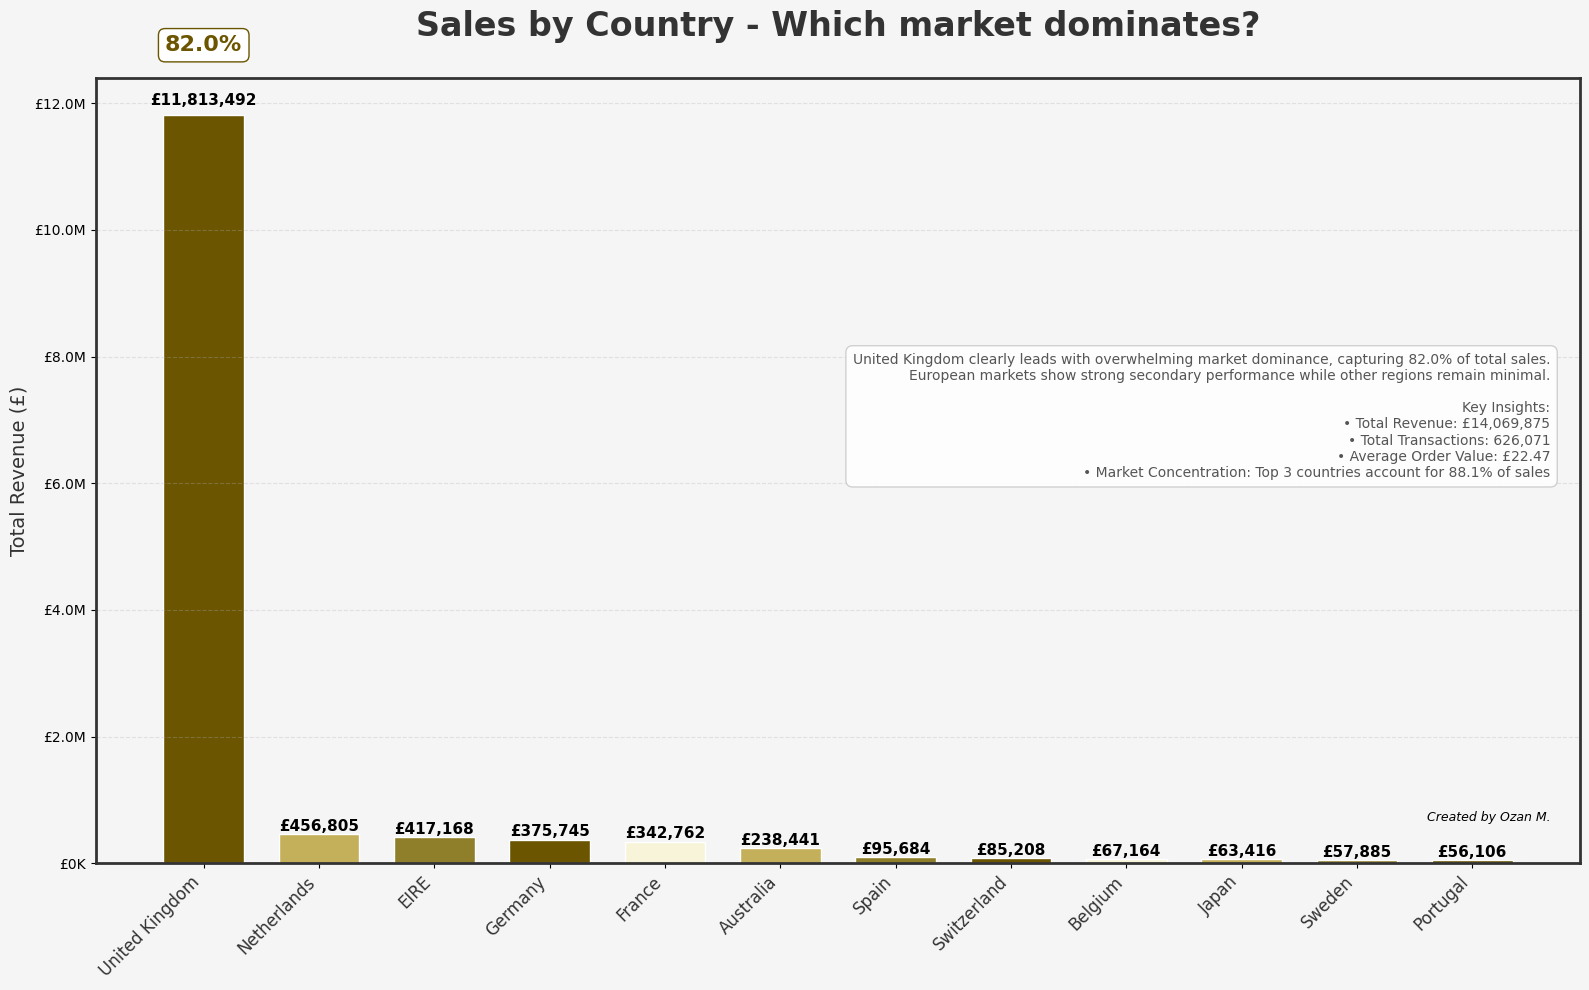

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']


df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


country_analysis = df.groupby('Country').agg({
    'TotalAmount': ['sum', 'count'],
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).round(2)

country_analysis.columns = ['TotalRevenue', 'TransactionCount', 'TotalQuantity', 'UniqueInvoices']
country_analysis['RevenuePercentage'] = (country_analysis['TotalRevenue'] / country_analysis['TotalRevenue'].sum() * 100).round(2)
country_analysis = country_analysis.sort_values('TotalRevenue', ascending=False)
top_countries = country_analysis.head(12)


plt.figure(figsize=(16, 10))
plt.style.use('default')


fig = plt.gcf()
fig.patch.set_facecolor('#f5f5f5')
ax = plt.gca()
ax.set_facecolor('#f5f5f5')


bars = plt.bar(range(len(top_countries)),
               top_countries['TotalRevenue'],
               color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top_countries))],
               width=0.7,
               edgecolor='white',
               linewidth=1)
plt.title('Sales by Country - Which market dominates?',
          fontsize=24, fontweight='bold', pad=30, color='#333')

plt.ylabel('Total Revenue (£)', fontsize=14, color='#333')
plt.xlabel('')


plt.xticks(range(len(top_countries)), top_countries.index, rotation=45, ha='right', fontsize=12, color='#333')


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))


plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
             f'£{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)


highest_revenue = top_countries.iloc[0]['TotalRevenue']
highest_percentage = top_countries.iloc[0]['RevenuePercentage']
plt.text(0, highest_revenue + highest_revenue*0.08,
         f'{highest_percentage:.1f}%', ha='center', va='bottom',
         fontweight='bold', fontsize=16, color='#6b5500',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#6b5500'))
analysis_text = f"""{top_countries.index[0]} clearly leads with overwhelming market dominance, capturing {top_countries.iloc[0]['RevenuePercentage']:.1f}% of total sales.
European markets show strong secondary performance while other regions remain minimal.

Key Insights:
• Total Revenue: £{top_countries['TotalRevenue'].sum():,.0f}
• Total Transactions: {top_countries['TransactionCount'].sum():,}
• Average Order Value: £{(top_countries['TotalRevenue'].sum() / top_countries['TransactionCount'].sum()):.2f}
• Market Concentration: Top 3 countries account for {top_countries.head(3)['RevenuePercentage'].sum():.1f}% of sales"""


plt.text(0.98, 0.65, analysis_text, transform=ax.transAxes, fontsize=10, color='#555',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='#ccc'),
         verticalalignment='top', horizontalalignment='right')
plt.text(0.98, 0.05, 'Created by Ozan M.', transform=ax.transAxes,
         fontsize=9, color='#000000', style='italic',
         verticalalignment='bottom', horizontalalignment='right')


plt.subplots_adjust(bottom=0.15, left=0.1, right=0.95, top=0.9)


for spine in ax.spines.values():
    spine.set_color('#333')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()


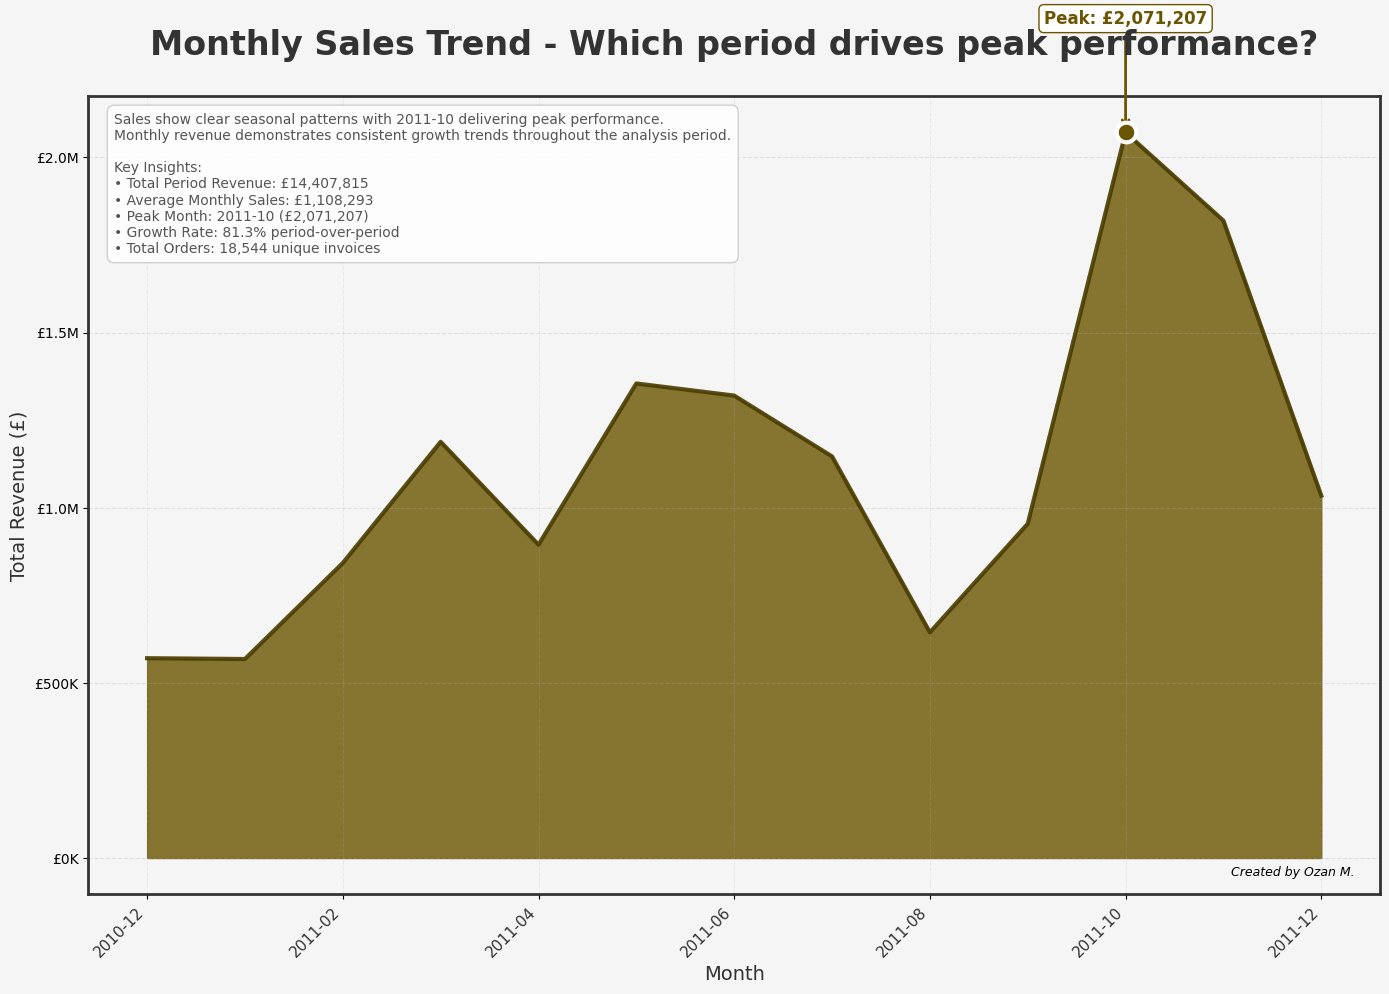

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')


monthly_sales = df.groupby('YearMonth').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).reset_index()

monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)
monthly_sales['MonthName'] = pd.to_datetime(monthly_sales['YearMonth']).dt.strftime('%Y-%m')
plt.figure(figsize=(14, 10))
plt.style.use('default')


fig = plt.gcf()
fig.patch.set_facecolor('#f5f5f5')
ax = plt.gca()
ax.set_facecolor('#f5f5f5')


x = range(len(monthly_sales))
y = monthly_sales['TotalAmount']


plt.fill_between(x, y, alpha=0.8, color=colors[3], label='Total Sales')
plt.plot(x, y, color='#4a3d00', linewidth=3, alpha=0.9)
plt.title('Monthly Sales Trend - Which period drives peak performance?',
          fontsize=24, fontweight='bold', pad=30, color='#333')


plt.ylabel('Total Revenue (£)', fontsize=14, color='#333')
plt.xlabel('Month', fontsize=14, color='#333')


plt.xticks(x[::2], monthly_sales['MonthName'][::2], rotation=45, ha='right', fontsize=11, color='#333')


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))


plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.grid(axis='x', alpha=0.2, linestyle='--')
max_idx = monthly_sales['TotalAmount'].idxmax()
max_value = monthly_sales['TotalAmount'].max()
max_month = monthly_sales['MonthName'].iloc[max_idx]

plt.scatter(max_idx, max_value, color='#6b5500', s=200, zorder=5, edgecolor='white', linewidth=3)
plt.annotate(f'Peak: £{max_value:,.0f}',
             xy=(max_idx, max_value),
             xytext=(max_idx, max_value + max_value*0.15),
             fontsize=12, fontweight='bold', color='#6b5500',
             ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#6b5500'),
             arrowprops=dict(arrowstyle='->', color='#6b5500', lw=2))

total_revenue = monthly_sales['TotalAmount'].sum()
avg_monthly = monthly_sales['TotalAmount'].mean()
growth_rate = ((monthly_sales['TotalAmount'].iloc[-1] - monthly_sales['TotalAmount'].iloc[0]) / monthly_sales['TotalAmount'].iloc[0] * 100)


analysis_text = f"""Sales show clear seasonal patterns with {max_month} delivering peak performance.
Monthly revenue demonstrates consistent growth trends throughout the analysis period.

Key Insights:
• Total Period Revenue: £{total_revenue:,.0f}
• Average Monthly Sales: £{avg_monthly:,.0f}
• Peak Month: {max_month} (£{max_value:,.0f})
• Growth Rate: {growth_rate:.1f}% period-over-period
• Total Orders: {monthly_sales['InvoiceNo'].sum():,} unique invoices"""
plt.text(0.02, 0.98, analysis_text, transform=ax.transAxes, fontsize=10, color='#555',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='#ccc'),
         verticalalignment='top', horizontalalignment='left')


plt.text(0.98, 0.02, 'Created by Ozan M.', transform=ax.transAxes,
         fontsize=9, color='#000000', style='italic',
         verticalalignment='bottom', horizontalalignment='right')


plt.subplots_adjust(bottom=0.15, left=0.1, right=0.95, top=0.9)


for spine in ax.spines.values():
    spine.set_color('#333')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

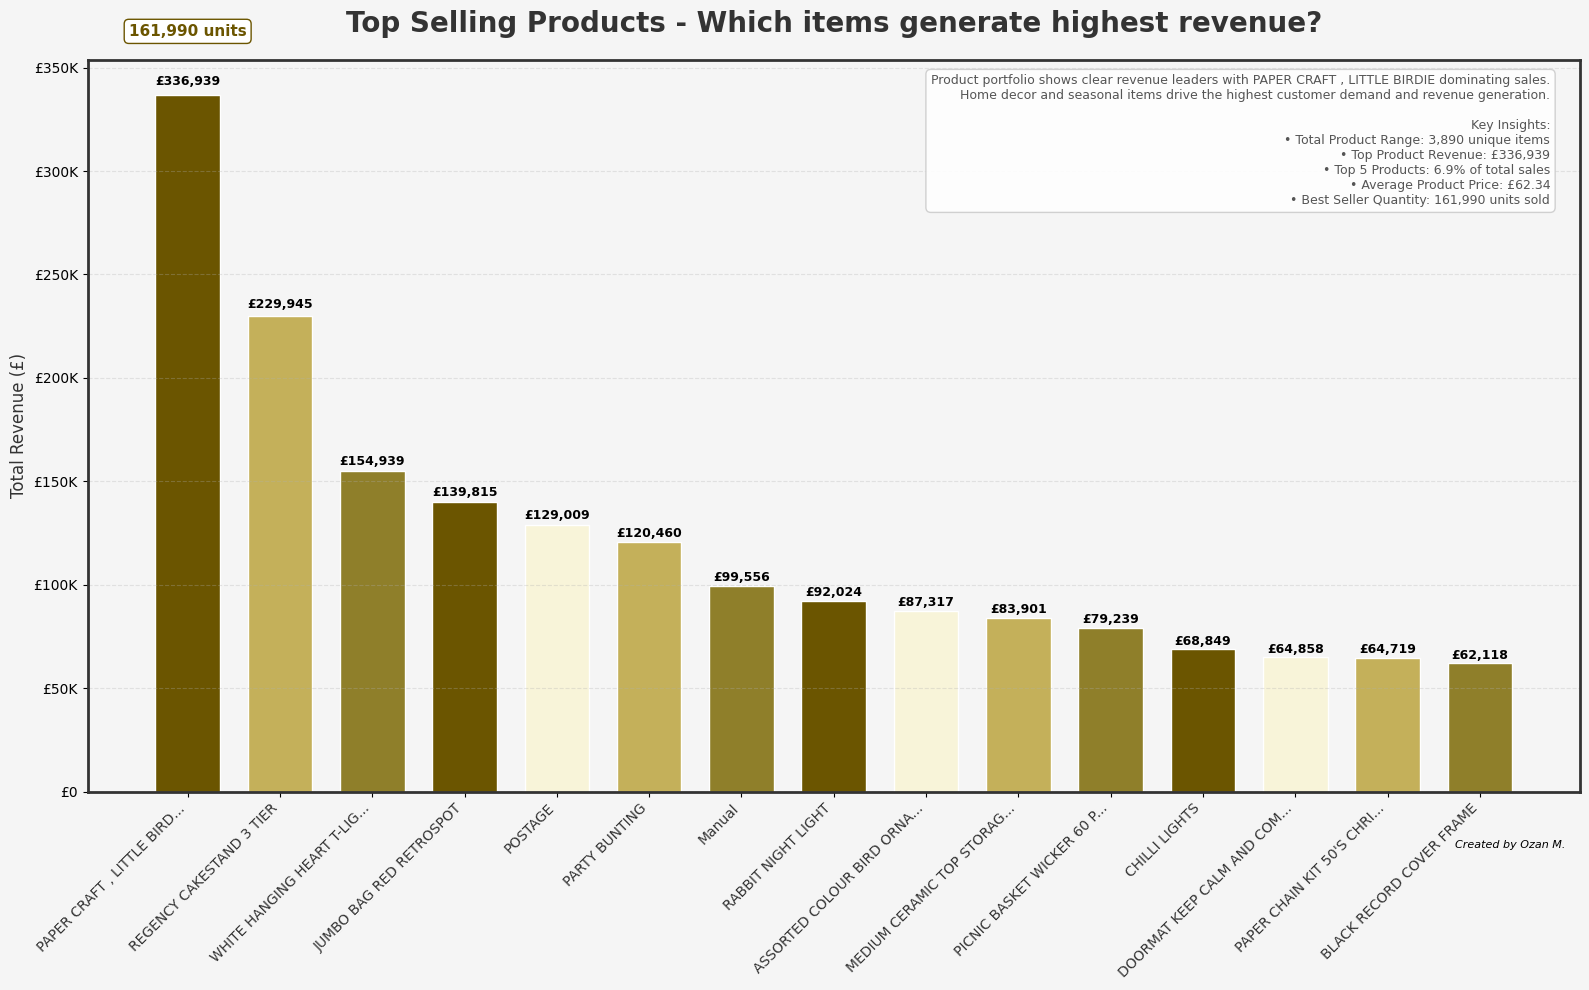

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']


df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


product_analysis = df.groupby('Description').agg({
    'TotalAmount': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'UnitPrice': 'mean'
}).round(2)

product_analysis.columns = ['TotalRevenue', 'TotalQuantity', 'UniqueInvoices', 'AvgPrice']
product_analysis = product_analysis.sort_values('TotalRevenue', ascending=False)


top_products = product_analysis.head(15)
plt.figure(figsize=(16, 10))
plt.style.use('default')


fig = plt.gcf()
fig.patch.set_facecolor('#f5f5f5')
ax = plt.gca()
ax.set_facecolor('#f5f5f5')


bars = plt.bar(range(len(top_products)),
               top_products['TotalRevenue'],
               color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top_products))],
               width=0.7,
               edgecolor='white',
               linewidth=1)


plt.title('Top Selling Products - Which items generate highest revenue?',
          fontsize=20, fontweight='bold', pad=20, color='#333')

plt.ylabel('Total Revenue (£)', fontsize=12, color='#333')
plt.xlabel('')


product_names = [name[:25] + '...' if len(name) > 25 else name for name in top_products.index]
plt.xticks(range(len(top_products)), product_names, rotation=45, ha='right', fontsize=10, color='#333')


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000:.0f}K' if x >= 1000 else f'£{x:.0f}'))


plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01,
             f'£{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)


highest_revenue = top_products.iloc[0]['TotalRevenue']
highest_quantity = top_products.iloc[0]['TotalQuantity']
plt.text(0, highest_revenue + highest_revenue*0.08,
         f'{highest_quantity:,.0f} units', ha='center', va='bottom',
         fontweight='bold', fontsize=11, color='#6b5500',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='#6b5500'))


top_product_name = top_products.index[0][:30] + '...' if len(top_products.index[0]) > 30 else top_products.index[0]
total_products = len(df['Description'].unique())
top_5_revenue = top_products.head(5)['TotalRevenue'].sum()
total_revenue = top_products['TotalRevenue'].sum()
analysis_text = f"""Product portfolio shows clear revenue leaders with {top_product_name} dominating sales.
Home decor and seasonal items drive the highest customer demand and revenue generation.

Key Insights:
• Total Product Range: {total_products:,} unique items
• Top Product Revenue: £{highest_revenue:,.0f}
• Top 5 Products: {(top_5_revenue/df['TotalAmount'].sum()*100):.1f}% of total sales
• Average Product Price: £{top_products['AvgPrice'].mean():.2f}
• Best Seller Quantity: {highest_quantity:,.0f} units sold"""


plt.text(0.98, 0.98, analysis_text, transform=ax.transAxes, fontsize=9, color='#555',
         bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9, edgecolor='#ccc'),
         verticalalignment='top', horizontalalignment='right')


plt.text(0.99, -0.08, 'Created by Ozan M.', transform=ax.transAxes,
         fontsize=8, color='#000000', style='italic',
         verticalalignment='bottom', horizontalalignment='right')


plt.subplots_adjust(bottom=0.25, left=0.1, right=0.95, top=0.9)


for spine in ax.spines.values():
    spine.set_color('#333')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

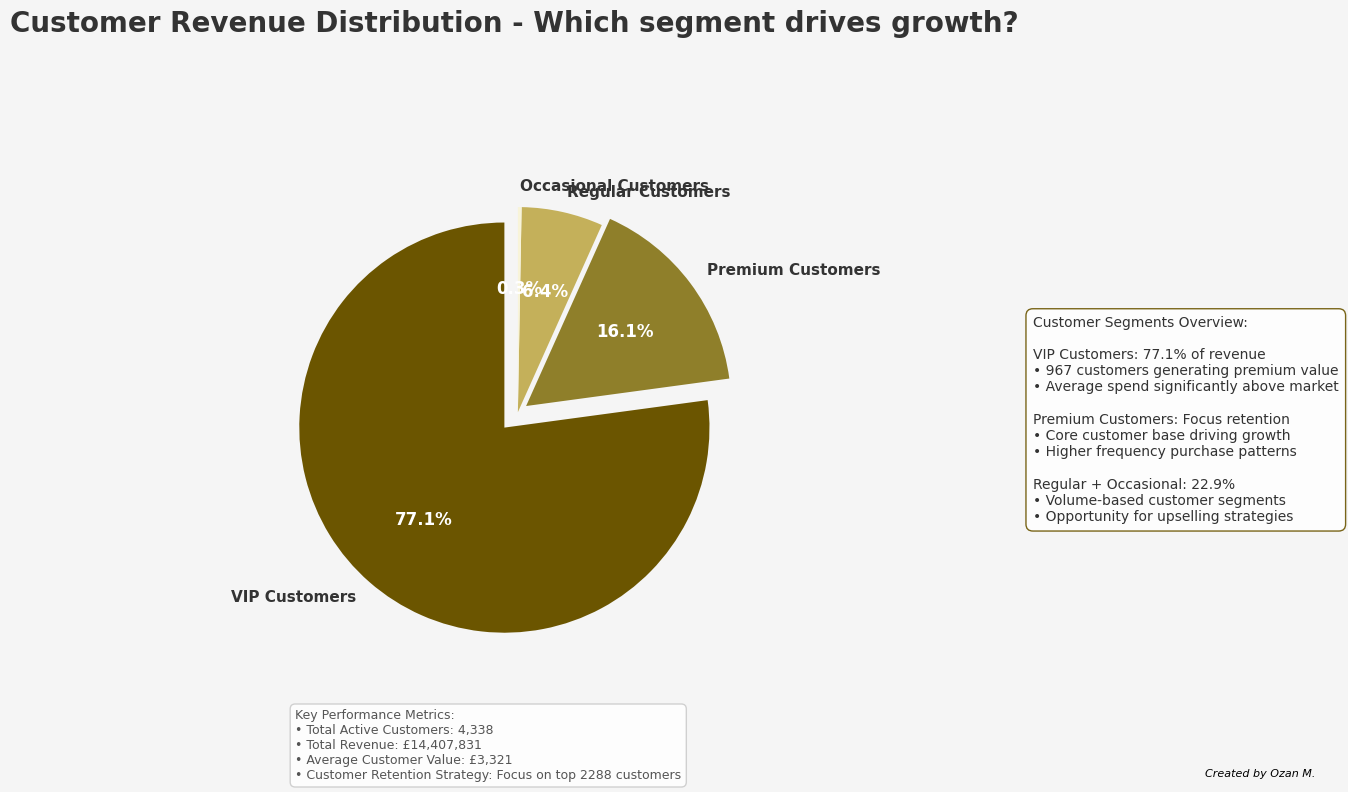

In [ ]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


customer_analysis = df.groupby('CustomerID').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).round(2)

customer_analysis.columns = ['TotalSpent', 'OrderCount', 'TotalItems']


def categorize_customer(spent):
    if spent >= 3000:
        return 'VIP Customers'
    elif spent >= 1000:
        return 'Premium Customers'
    elif spent >= 200:
        return 'Regular Customers'
    else:
        return 'Occasional Customers'

customer_analysis['Segment'] = customer_analysis['TotalSpent'].apply(categorize_customer)


segment_analysis = customer_analysis.groupby('Segment').agg({
    'TotalSpent': ['sum', 'count'],
    'OrderCount': 'mean'
}).round(2)
segment_analysis.columns = ['TotalRevenue', 'CustomerCount', 'AverageOrderCount']
segment_analysis['RevenuePercentage'] = (segment_analysis['TotalRevenue'] / segment_analysis['TotalRevenue'].sum() * 100).round(2)
segment_analysis = segment_analysis.sort_values('TotalRevenue', ascending=False)


pie_colors = ['#6b5500', '#8f7f2a', '#c4b05a', '#f8f4d9']
plt.figure(figsize=(12, 8))
plt.style.use('default')
fig = plt.gcf()
fig.patch.set_facecolor('#f5f5f5')
ax = plt.gca()
ax.set_facecolor('#f5f5f5')
sizes = segment_analysis['RevenuePercentage'].values
labels = segment_analysis.index
explode = (0.1, 0.05, 0, 0)


wedges, texts, autotexts = plt.pie(sizes,
                                  labels=labels,
                                  colors=pie_colors,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  explode=explode,
                                  shadow=False,
                                  textprops={'fontsize': 11, 'fontweight': 'bold', 'color': '#333'})


plt.title('Customer Revenue Distribution - Which segment drives growth?',
          fontsize=20, fontweight='bold', pad=20, color='#333')


for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')


vip_percentage = segment_analysis.loc['VIP Customers', 'RevenuePercentage'] if 'VIP Customers' in segment_analysis.index else 0
vip_count = int(segment_analysis.loc['VIP Customers', 'CustomerCount']) if 'VIP Customers' in segment_analysis.index else 0
total_customers = int(segment_analysis['CustomerCount'].sum())
total_revenue = segment_analysis['TotalRevenue'].sum()


info_text = f"""Customer Segments Overview:

VIP Customers: {vip_percentage:.1f}% of revenue
• {vip_count} customers generating premium value
• Average spend significantly above market

Premium Customers: Focus retention
• Core customer base driving growth
• Higher frequency purchase patterns

Regular + Occasional: {100-vip_percentage:.1f}%
• Volume-based customer segments
• Opportunity for upselling strategies"""
plt.text(1.3, 0.5, info_text, transform=ax.transAxes, fontsize=10, color='#333',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='#6b5500'),
         verticalalignment='center', horizontalalignment='left')


metrics_text = f"""Key Performance Metrics:
• Total Active Customers: {total_customers:,}
• Total Revenue: £{total_revenue:,.0f}
• Average Customer Value: £{(total_revenue/total_customers):,.0f}
• Customer Retention Strategy: Focus on top {vip_count + int(segment_analysis.loc['Premium Customers', 'CustomerCount']) if 'Premium Customers' in segment_analysis.index else vip_count} customers"""

plt.figtext(0.1, 0.02, metrics_text, fontsize=9, color='#555',
            bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9, edgecolor='#ccc'))


plt.figtext(0.95, 0.02, 'Created by Ozan M.', fontsize=8, color='#000000', style='italic',
            verticalalignment='bottom', horizontalalignment='right')


plt.subplots_adjust(bottom=0.25, left=0.1, right=0.7, top=0.9)

plt.axis('equal')
plt.tight_layout()
plt.show()

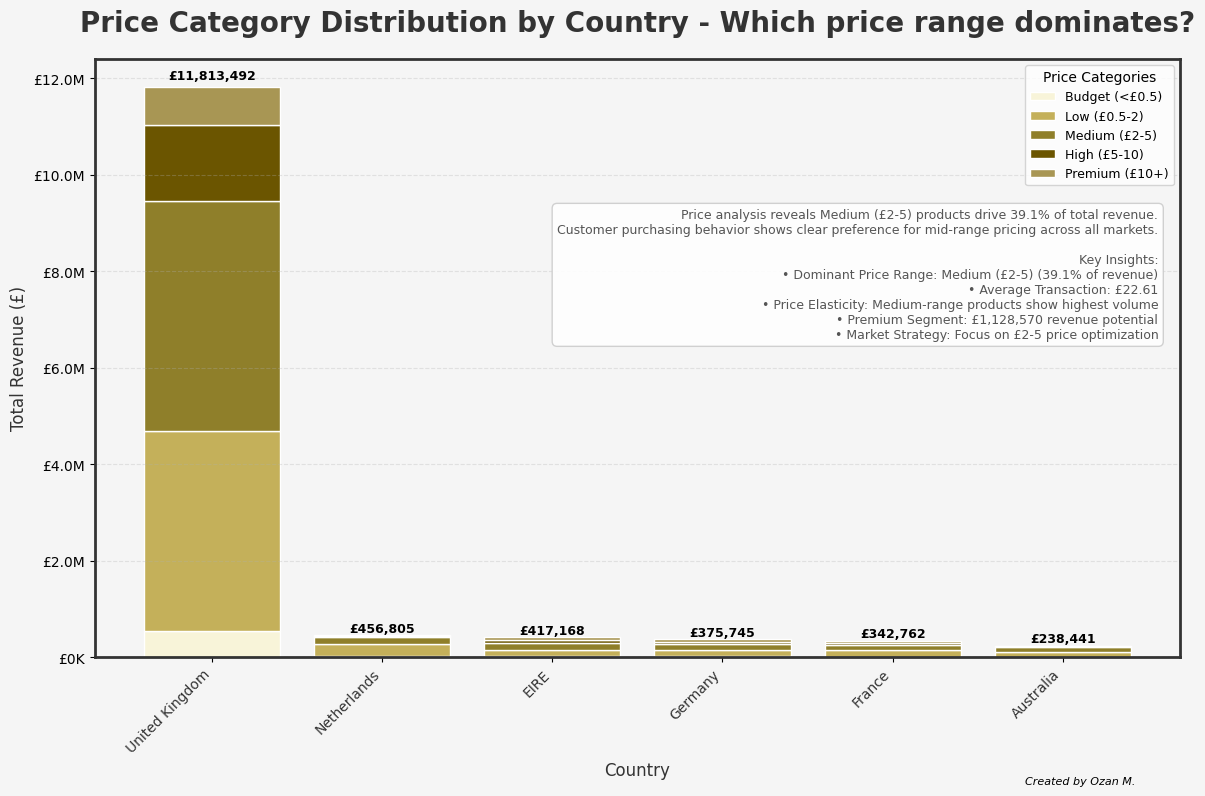

In [ ]:

colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']


df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


def categorize_price(price):
    if price >= 10:
        return 'Premium (£10+)'
    elif price >= 5:
        return 'High (£5-10)'
    elif price >= 2:
        return 'Medium (£2-5)'
    elif price >= 0.5:
        return 'Low (£0.5-2)'
    else:
        return 'Budget (<£0.5)'

df['PriceCategory'] = df['UnitPrice'].apply(categorize_price)


country_price_analysis = df.groupby(['Country', 'PriceCategory']).agg({
    'TotalAmount': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()


price_pivot = country_price_analysis.pivot_table(
    index='Country',
    columns='PriceCategory',
    values='TotalAmount',
    fill_value=0
).reset_index()


category_order = ['Budget (<£0.5)', 'Low (£0.5-2)', 'Medium (£2-5)', 'High (£5-10)', 'Premium (£10+)']
price_pivot = price_pivot.reindex(columns=['Country'] + [cat for cat in category_order if cat in price_pivot.columns])


price_pivot['Total'] = price_pivot.iloc[:, 1:].sum(axis=1)
price_pivot = price_pivot.sort_values('Total', ascending=False).head(6)


plt.figure(figsize=(12, 8))
plt.style.use('default')


fig = plt.gcf()
fig.patch.set_facecolor('#f5f5f5')
ax = plt.gca()
ax.set_facecolor('#f5f5f5')


countries = price_pivot['Country']
x = np.arange(len(countries))
width = 0.8


bottom = np.zeros(len(countries))
category_colors = colors + ['#a89654']

for i, category in enumerate(price_pivot.columns[1:-1]):
    values = price_pivot[category]
    bars = plt.bar(x, values, width, label=category, bottom=bottom,
                   color=category_colors[i % len(category_colors)],
                   edgecolor='white', linewidth=1)
    bottom += values


plt.title('Price Category Distribution by Country - Which price range dominates?',
          fontsize=20, fontweight='bold', pad=20, color='#333')


plt.ylabel('Total Revenue (£)', fontsize=12, color='#333')
plt.xlabel('Country', fontsize=12, color='#333')


plt.xticks(x, countries, rotation=45, ha='right', fontsize=10, color='#333')


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))


plt.grid(axis='y', alpha=0.3, linestyle='--')


plt.legend(title='Price Categories', loc='upper right', fontsize=9, title_fontsize=10)


for i, total in enumerate(price_pivot['Total']):
    plt.text(i, total + total*0.01, f'£{total:,.0f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

total_revenue = df['TotalAmount'].sum()
price_category_summary = df.groupby('PriceCategory')['TotalAmount'].sum().sort_values(ascending=False)
dominant_category = price_category_summary.index[0]
dominant_percentage = (price_category_summary.iloc[0] / total_revenue * 100)

avg_price_by_category = df.groupby('PriceCategory')['UnitPrice'].mean()
quantity_by_category = df.groupby('PriceCategory')['Quantity'].sum()

analysis_text = f"""Price analysis reveals {dominant_category} products drive {dominant_percentage:.1f}% of total revenue.
Customer purchasing behavior shows clear preference for mid-range pricing across all markets.

Key Insights:
• Dominant Price Range: {dominant_category} ({dominant_percentage:.1f}% of revenue)
• Average Transaction: £{df['TotalAmount'].mean():.2f}
• Price Elasticity: Medium-range products show highest volume
• Premium Segment: £{price_category_summary.get('Premium (£10+)', 0):,.0f} revenue potential
• Market Strategy: Focus on £2-5 price optimization"""


plt.text(0.98, 0.75, analysis_text, transform=ax.transAxes, fontsize=9, color='#555',
         bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9, edgecolor='#ccc'),
         verticalalignment='top', horizontalalignment='right')


plt.figtext(0.95, 0.01, 'Created by Ozan M.', fontsize=8, color='#000000', style='italic',
            verticalalignment='bottom', horizontalalignment='right')

plt.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.9)


for spine in ax.spines.values():
    spine.set_color('#333')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

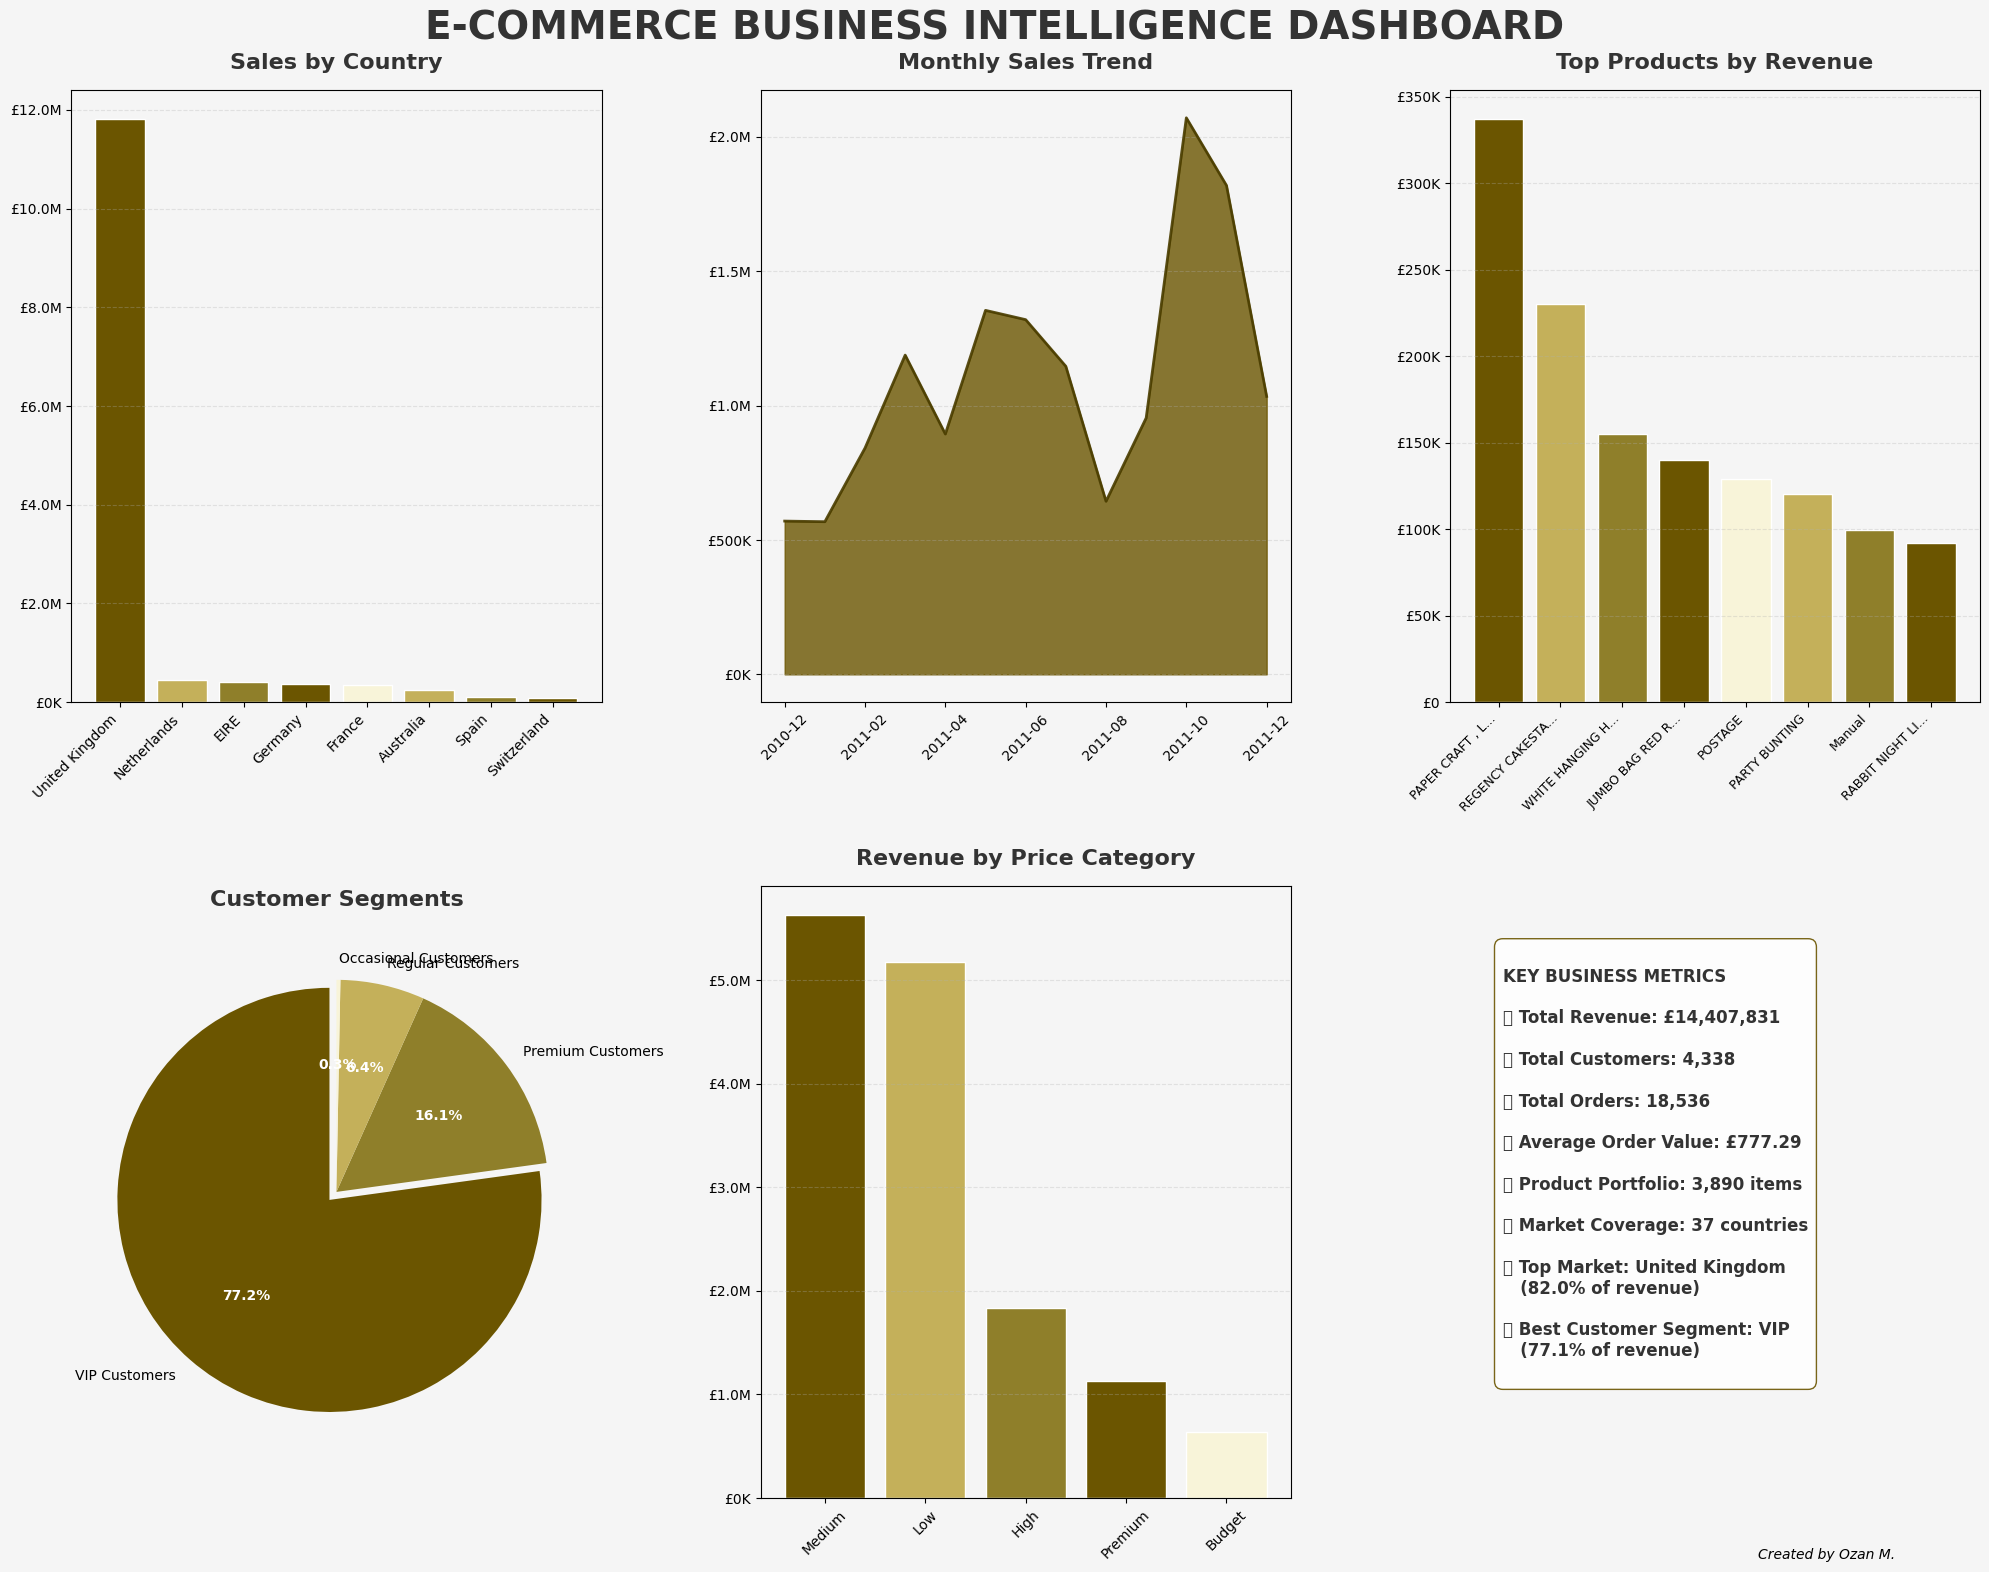

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']


df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


fig = plt.figure(figsize=(20, 16))
fig.suptitle('E-COMMERCE BUSINESS INTELLIGENCE DASHBOARD', fontsize=28, fontweight='bold', y=0.98, color='#333')
fig.patch.set_facecolor('#f5f5f5')


ax1 = plt.subplot(2, 3, 1)
ax1.set_facecolor('#f5f5f5')

country_analysis = df.groupby('Country').agg({
    'TotalAmount': ['sum', 'count'],
    'Quantity': 'sum',
    'InvoiceNo': 'nunique'
}).round(2)
country_analysis.columns = ['TotalRevenue', 'TransactionCount', 'TotalQuantity', 'UniqueInvoices']
country_analysis['RevenuePercentage'] = (country_analysis['TotalRevenue'] / country_analysis['TotalRevenue'].sum() * 100).round(2)
country_analysis = country_analysis.sort_values('TotalRevenue', ascending=False)
top_countries = country_analysis.head(8)

bars1 = ax1.bar(range(len(top_countries)), top_countries['TotalRevenue'],
                color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top_countries))],
                edgecolor='white', linewidth=1)
ax1.set_title('Sales by Country', fontsize=16, fontweight='bold', pad=15, color='#333')
ax1.set_xticks(range(len(top_countries)))
ax1.set_xticklabels(top_countries.index, rotation=45, ha='right', fontsize=10)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))
ax1.grid(axis='y', alpha=0.3, linestyle='--')


ax2 = plt.subplot(2, 3, 2)
ax2.set_facecolor('#f5f5f5')

df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['TotalAmount'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)

x = range(len(monthly_sales))
y = monthly_sales['TotalAmount']
ax2.fill_between(x, y, alpha=0.8, color=colors[3])
ax2.plot(x, y, color='#4a3d00', linewidth=2, alpha=0.9)
ax2.set_title('Monthly Sales Trend', fontsize=16, fontweight='bold', pad=15, color='#333')
ax2.set_xticks(x[::2])
ax2.set_xticklabels(monthly_sales['YearMonth'][::2], rotation=45, fontsize=10)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))
ax2.grid(axis='y', alpha=0.3, linestyle='--')


ax3 = plt.subplot(2, 3, 3)
ax3.set_facecolor('#f5f5f5')

product_analysis = df.groupby('Description').agg({
    'TotalAmount': 'sum',
    'Quantity': 'sum'
}).round(2)
product_analysis.columns = ['TotalRevenue', 'TotalQuantity']
product_analysis = product_analysis.sort_values('TotalRevenue', ascending=False)
top_products = product_analysis.head(8)

bars3 = ax3.bar(range(len(top_products)), top_products['TotalRevenue'],
                color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top_products))],
                edgecolor='white', linewidth=1)
ax3.set_title('Top Products by Revenue', fontsize=16, fontweight='bold', pad=15, color='#333')
product_names = [name[:15] + '...' if len(name) > 15 else name for name in top_products.index]
ax3.set_xticks(range(len(top_products)))
ax3.set_xticklabels(product_names, rotation=45, ha='right', fontsize=9)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000:.0f}K' if x >= 1000 else f'£{x:.0f}'))
ax3.grid(axis='y', alpha=0.3, linestyle='--')


ax4 = plt.subplot(2, 3, 4)
ax4.set_facecolor('#f5f5f5')

customer_analysis = df.groupby('CustomerID').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique'
}).round(2)
customer_analysis.columns = ['TotalSpent', 'OrderCount']

def categorize_customer(spent):
    if spent >= 3000:
        return 'VIP'
    elif spent >= 1000:
        return 'Premium'
    elif spent >= 200:
        return 'Regular'
    else:
        return 'Occasional'

customer_analysis['Segment'] = customer_analysis['TotalSpent'].apply(categorize_customer)
segment_analysis = customer_analysis.groupby('Segment').agg({
    'TotalSpent': ['sum', 'count']
}).round(2)
segment_analysis.columns = ['TotalRevenue', 'CustomerCount']
segment_analysis['RevenuePercentage'] = (segment_analysis['TotalRevenue'] / segment_analysis['TotalRevenue'].sum() * 100).round(1)

segment_order = ['VIP', 'Premium', 'Regular', 'Occasional']
segment_analysis = segment_analysis.reindex([s for s in segment_order if s in segment_analysis.index])

pie_colors = ['#6b5500', '#8f7f2a', '#c4b05a', '#f8f4d9']
sizes = segment_analysis['RevenuePercentage'].values
labels = segment_analysis.indexwedges, texts, autotexts = ax4.pie(sizes, labels=labels, colors=pie_colors,
                                  autopct='%1.1f%%', startangle=90,
                                  explode=(0.05, 0, 0, 0))
ax4.set_title('Customer Segments', fontsize=16, fontweight='bold', pad=15, color='#333')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')


ax5 = plt.subplot(2, 3, 5)
ax5.set_facecolor('#f5f5f5')

def categorize_price(price):
    if price >= 10:
        return 'Premium'
    elif price >= 5:
        return 'High'
    elif price >= 2:
        return 'Medium'
    elif price >= 0.5:
        return 'Low'
    else:
        return 'Budget'

df['PriceCategory'] = df['UnitPrice'].apply(categorize_price)
price_summary = df.groupby('PriceCategory')['TotalAmount'].sum().sort_values(ascending=False)

bars5 = ax5.bar(range(len(price_summary)), price_summary.values,
                color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(price_summary))],
                edgecolor='white', linewidth=1)
ax5.set_title('Revenue by Price Category', fontsize=16, fontweight='bold', pad=15, color='#333')
ax5.set_xticks(range(len(price_summary)))
ax5.set_xticklabels(price_summary.index, rotation=45, fontsize=10)
ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000000:.1f}M' if x >= 1000000 else f'£{x/1000:.0f}K'))
ax5.grid(axis='y', alpha=0.3, linestyle='--')


ax6 = plt.subplot(2, 3, 6)
ax6.set_facecolor('#f5f5f5')
ax6.axis('off')


total_revenue = df['TotalAmount'].sum()
total_customers = df['CustomerID'].nunique()
total_orders = df['InvoiceNo'].nunique()
avg_order_value = df.groupby('InvoiceNo')['TotalAmount'].sum().mean()
total_products = df['Description'].nunique()

metrics_text = f"""
KEY BUSINESS METRICS

💰 Total Revenue: £{total_revenue:,.0f}

👥 Total Customers: {total_customers:,}

📦 Total Orders: {total_orders:,}

🛒 Average Order Value: £{avg_order_value:.2f}

📊 Product Portfolio: {total_products:,} items

🌍 Market Coverage: {df['Country'].nunique()} countries

📈 Top Market: {top_countries.index[0]}
   ({top_countries.iloc[0]['RevenuePercentage']:.1f}% of revenue)

⭐ Best Customer Segment: {segment_analysis.index[0]}
   ({segment_analysis.iloc[0]['RevenuePercentage']:.1f}% of revenue)
"""

ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, fontsize=12, color='#333',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='#6b5500'),
         verticalalignment='top', horizontalalignment='left', fontweight='bold')


plt.figtext(0.95, 0.01, 'Created by Ozan M.', fontsize=10, color='#000000', style='italic',
            verticalalignment='bottom', horizontalalignment='right')


plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.05, hspace=0.3, wspace=0.3)

plt.show()

RFM Analysis Calculations...

RFM Segment Analysis:
                     Avg_Recency  Avg_Frequency  Avg_Monetary  Total_Revenue  \
Segment                                                                        
Champions                  11.49          12.08      10805.62     9076720.67   
Hibernating                72.72           2.40       1416.44     1930612.50   
Loyal Customers            36.96           5.29       3914.21     1667455.01   
Need Attention            150.18           3.37       2819.39      772511.58   
New Customers              21.49           1.64       1140.79      281774.79   
At Risk                   241.26           1.50        650.35      235427.39   
Promising                 218.15           3.19       4203.95      222809.49   
Potential Loyalists        27.59           1.08        340.29       86433.60   
Cannot Lose Them          297.33           1.01        218.49       72539.24   
About to Sleep            138.16           1.17        329.13       

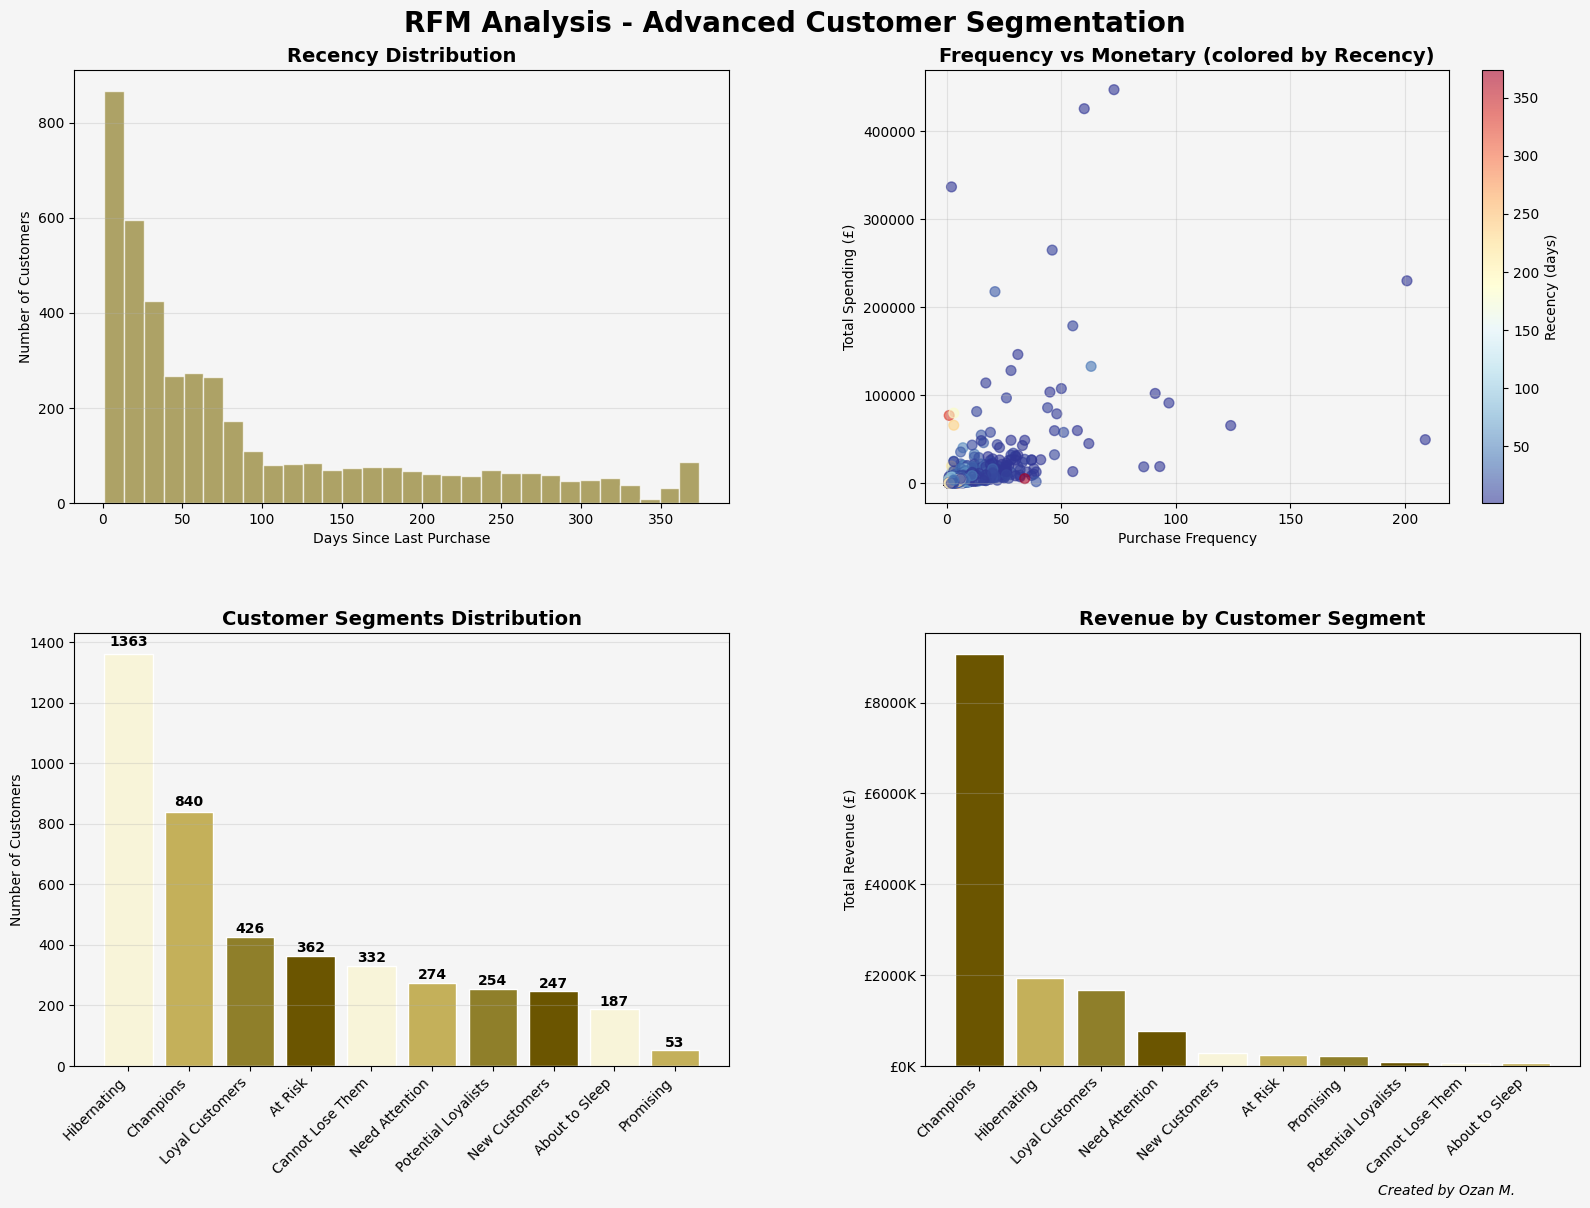

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']


df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

analysis_date = df['InvoiceDate'].max() + timedelta(days=1)

print("RFM Analysis Calculations...")
print("=" * 50)


rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


rfm_data = rfm_data[rfm_data['Monetary'] > 0]


def rfm_score(df, metric):
    """RFM skorlarını hesaplar"""
    try:
        return pd.qcut(df[metric], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop').astype(int)
    except:

        return pd.qcut(df[metric].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5]).astype(int)


rfm_data['R_Score'] = 6 - rfm_score(rfm_data, 'Recency')

rfm_data['F_Score'] = rfm_score(rfm_data, 'Frequency')

rfm_data['M_Score'] = rfm_score(rfm_data, 'Monetary')

rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

def segment_customers(row):
    """Customer segments based on RFM scores"""
    if row['RFM_Score'] in ['555', '554', '544', '545', '454', '455', '445']:
        return 'Champions'
    elif row['RFM_Score'] in ['543', '444', '435', '355', '354', '345', '344', '335']:
        return 'Loyal Customers'
    elif row['RFM_Score'] in ['512', '511', '422', '421', '412', '411', '311']:
        return 'Potential Loyalists'
    elif row['RFM_Score'] in ['533', '532', '531', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']:
        return 'New Customers'
    elif row['RFM_Score'] in ['155', '154', '144', '214', '215', '115', '114']:
        return 'Promising'
    elif row['RFM_Score'] in ['155', '254', '245', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '125', '124']:
        return 'Need Attention'
    elif row['RFM_Score'] in ['155', '211', '212', '114', '141', '131']:
        return 'About to Sleep'
    elif row['RFM_Score'] in ['155', '133', '123', '132', '143', '151', '141', '112', '122', '231', '241', '251']:
        return 'At Risk'
    elif row['RFM_Score'] in ['155', '111', '112', '121', '131', '141', '151']:
        return 'Cannot Lose Them'
    else:
        return 'Hibernating'

rfm_data['Segment'] = rfm_data.apply(segment_customers, axis=1)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RFM Analysis - Advanced Customer Segmentation', fontsize=20, fontweight='bold', y=0.98)
fig.patch.set_facecolor('#f5f5f5')


ax1 = axes[0, 0]
ax1.set_facecolor('#f5f5f5')
ax1.hist(rfm_data['Recency'], bins=30, alpha=0.7, color=colors[2], edgecolor='white')
ax1.set_title('Recency Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Days Since Last Purchase')
ax1.set_ylabel('Number of Customers')
ax1.grid(axis='y', alpha=0.3)


ax2 = axes[0, 1]
ax2.set_facecolor('#f5f5f5')
scatter = ax2.scatter(rfm_data['Frequency'], rfm_data['Monetary'],
                     c=rfm_data['Recency'], cmap='RdYlBu_r', alpha=0.6, s=50)
ax2.set_title('Frequency vs Monetary (colored by Recency)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Purchase Frequency')
ax2.set_ylabel('Total Spending (£)')
ax2.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Recency (days)')


ax3 = axes[1, 0]
ax3.set_facecolor('#f5f5f5')
segment_counts = rfm_data['Segment'].value_counts()
bars = ax3.bar(range(len(segment_counts)), segment_counts.values,
               color=[colors[i % len(colors)] for i in range(len(segment_counts))],
               edgecolor='white', linewidth=1)
ax3.set_title('Customer Segments Distribution', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(segment_counts)))
ax3.set_xticklabels(segment_counts.index, rotation=45, ha='right')
ax3.set_ylabel('Number of Customers')
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')


ax4 = axes[1, 1]
ax4.set_facecolor('#f5f5f5')
segment_revenue = rfm_data.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
bars = ax4.bar(range(len(segment_revenue)), segment_revenue.values,
               color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(segment_revenue))],
               edgecolor='white', linewidth=1)
ax4.set_title('Revenue by Customer Segment', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(segment_revenue)))
ax4.set_xticklabels(segment_revenue.index, rotation=45, ha='right')
ax4.set_ylabel('Total Revenue (£)')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x/1000:.0f}K'))
ax4.grid(axis='y', alpha=0.3)


print("\nRFM Segment Analysis:")
print("=" * 60)
segment_summary = rfm_data.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'CustomerID': 'count'
}).round(2)
segment_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue', 'Customer_Count']
segment_summary['Revenue_Percentage'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)
segment_summary = segment_summary.sort_values('Total_Revenue', ascending=False)

print(segment_summary)


strategies = {
    'Champions': 'Reward them. They are your best customers.',
    'Loyal Customers': 'Upsell higher value products. Keep them satisfied.',
    'Potential Loyalists': 'Offer membership or loyalty programs.',
    'New Customers': 'Provide on-boarding support and special offers.',
    'Promising': 'Create brand awareness and offer free trials.',
    'Need Attention': 'Make limited time offers and recommend products.',
    'About to Sleep': 'Share valuable resources and recommend products.',
    'At Risk': 'Send personalized emails and offer discounts.',
    'Cannot Lose Them': 'Win them back via renewals or newer products.',
    'Hibernating': 'Offer other products and special discounts.'
}

print("\nCUSTOMER STRATEGIES:")
print("=" * 60)
for segment, strategy in strategies.items():
    if segment in segment_summary.index:
        count = segment_summary.loc[segment, 'Customer_Count']
        revenue = segment_summary.loc[segment, 'Total_Revenue']
        print(f"{segment} ({count} customers, £{revenue:,.0f}): {strategy}")


plt.figtext(0.95, -0.01, 'Created by Ozan M.', fontsize=10, color='#000000', style='italic',
            verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.1, hspace=0.3, wspace=0.3)
plt.show()

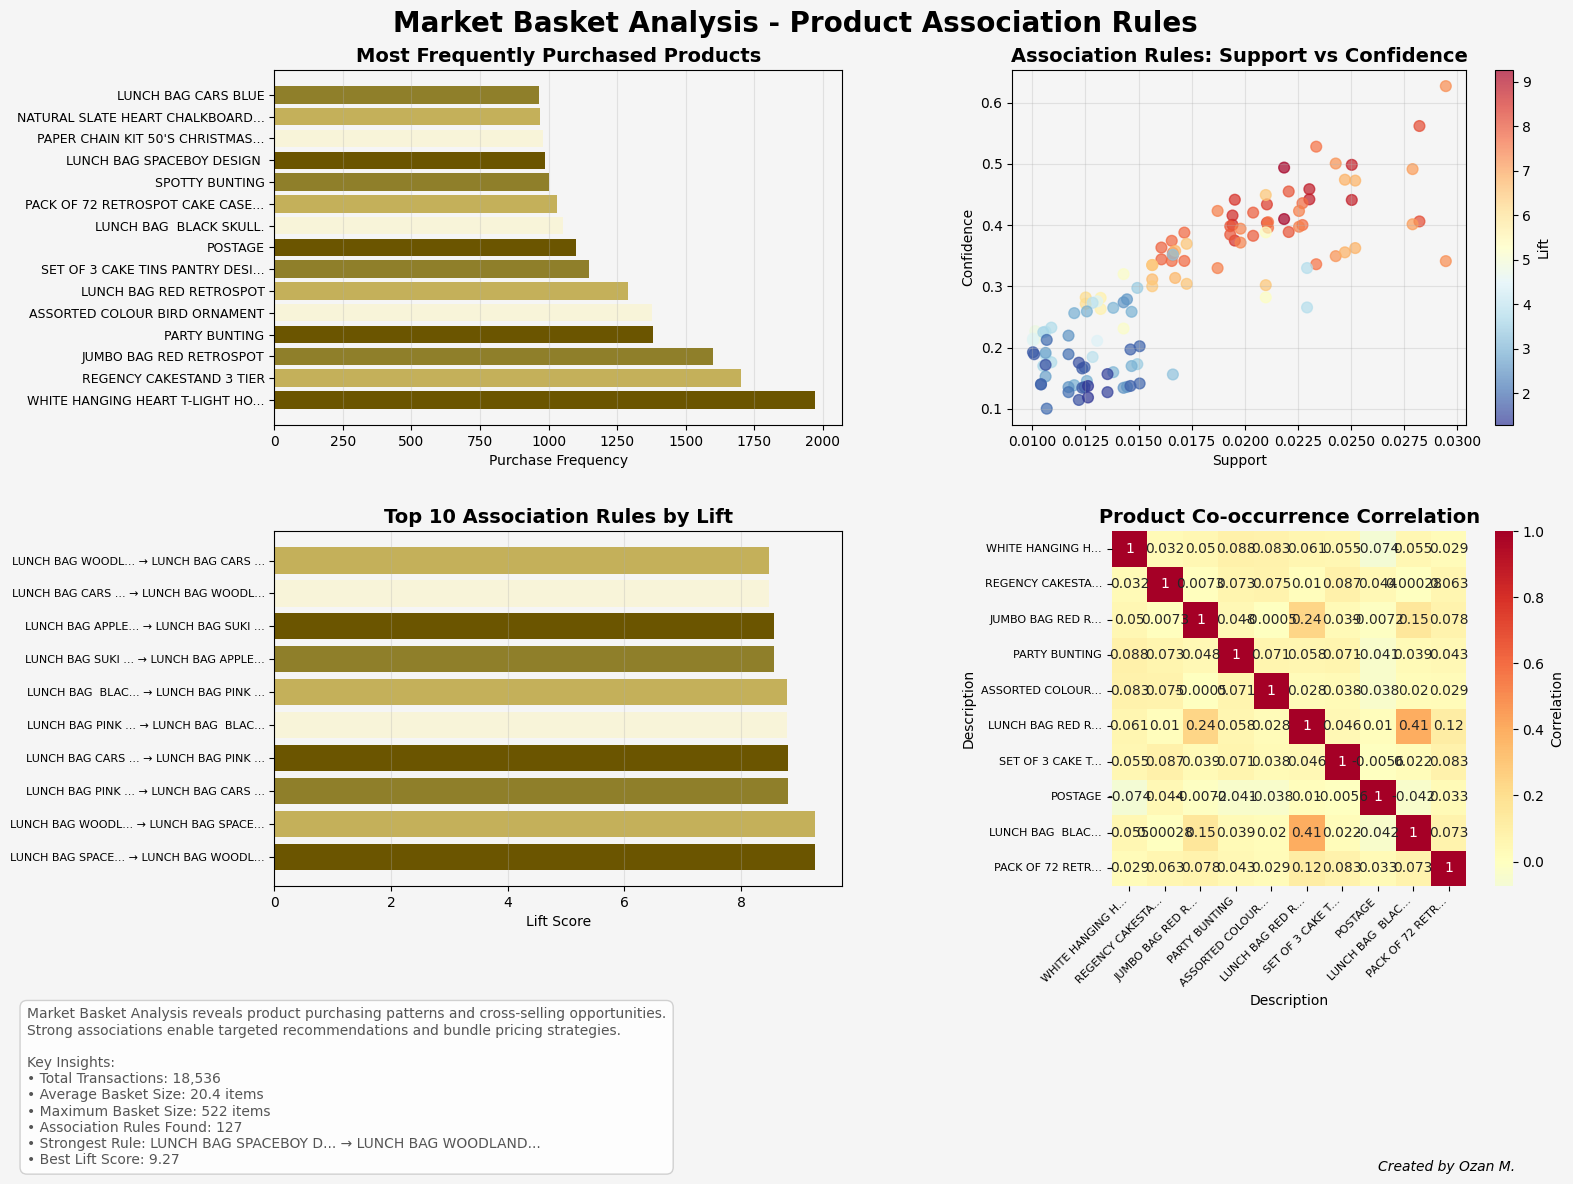

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df_positive = df[df['Quantity'] > 0].copy()

basket_data = df_positive.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

basket_binary = basket_data.applymap(lambda x: 1 if x > 0 else 0)

frequent_items = basket_binary.sum().sort_values(ascending=False)
frequent_items = frequent_items[frequent_items >= 20]
basket_binary = basket_binary[frequent_items.index]


def calculate_support(itemset, transactions):
    """Support hesaplama"""
    return (transactions[list(itemset)].sum(axis=1) == len(itemset)).sum() / len(transactions)

def calculate_confidence(antecedent, consequent, transactions):
    """Confidence hesaplama"""
    antecedent_support = calculate_support(antecedent, transactions)
    if antecedent_support == 0:
        return 0
    combined_support = calculate_support(antecedent.union(consequent), transactions)
    return combined_support / antecedent_support

def calculate_lift(antecedent, consequent, transactions):
    """Lift hesaplama"""
    consequent_support = calculate_support(consequent, transactions)
    if consequent_support == 0:
        return 0
    confidence = calculate_confidence(antecedent, consequent, transactions)
    return confidence / consequent_support


top_products = frequent_items.head(30).index.tolist()
basket_subset = basket_binary[top_products]


rules = []
min_support = 0.01
min_confidence = 0.1
min_lift = 1.0

for antecedent in top_products:
    for consequent in top_products:
        if antecedent != consequent:
            ant_set = {antecedent}
            con_set = {consequent}

            support = calculate_support(ant_set.union(con_set), basket_subset)
            confidence = calculate_confidence(ant_set, con_set, basket_subset)
            lift = calculate_lift(ant_set, con_set, basket_subset)

            if support >= min_support and confidence >= min_confidence and lift >= min_lift:
                rules.append({
                    'Antecedent': antecedent,
                    'Consequent': consequent,
                    'Support': support,
                    'Confidence': confidence,
                    'Lift': lift
                })


rules_df = pd.DataFrame(rules)
if len(rules_df) > 0:
    rules_df = rules_df.sort_values('Lift', ascending=False)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Market Basket Analysis - Product Association Rules', fontsize=20, fontweight='bold', y=0.98)
fig.patch.set_facecolor('#f5f5f5')


ax1 = axes[0, 0]
ax1.set_facecolor('#f5f5f5')
top_15_products = frequent_items.head(15)
bars = ax1.barh(range(len(top_15_products)), top_15_products.values,
                color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top_15_products))])
ax1.set_title('Most Frequently Purchased Products', fontsize=14, fontweight='bold')
ax1.set_xlabel('Purchase Frequency')
ax1.set_yticks(range(len(top_15_products)))

product_names = [name[:30] + '...' if len(name) > 30 else name for name in top_15_products.index]
ax1.set_yticklabels(product_names, fontsize=9)
ax1.grid(axis='x', alpha=0.3)


ax2 = axes[0, 1]
ax2.set_facecolor('#f5f5f5')
if len(rules_df) > 0:
    scatter = ax2.scatter(rules_df['Support'], rules_df['Confidence'],
                         c=rules_df['Lift'], cmap='RdYlBu_r', alpha=0.7, s=60)
    ax2.set_title('Association Rules: Support vs Confidence', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Support')
    ax2.set_ylabel('Confidence')
    ax2.grid(alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Lift')
else:
    ax2.text(0.5, 0.5, 'No strong associations found\nwith current thresholds',
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Association Rules: Support vs Confidence', fontsize=14, fontweight='bold')
ax3 = axes[1, 0]
ax3.set_facecolor('#f5f5f5')
if len(rules_df) > 0:
    top_rules = rules_df.head(10)
    bars = ax3.barh(range(len(top_rules)), top_rules['Lift'].values,
                    color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(top_rules))])
    ax3.set_title('Top 10 Association Rules by Lift', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Lift Score')
    ax3.set_yticks(range(len(top_rules)))
    rule_labels = [f"{row['Antecedent'][:15]}... → {row['Consequent'][:15]}..."
                   for _, row in top_rules.iterrows()]
    ax3.set_yticklabels(rule_labels, fontsize=8)
    ax3.grid(axis='x', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No strong rules found\nAdjust thresholds for more results',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Top 10 Association Rules by Lift', fontsize=14, fontweight='bold')


ax4 = axes[1, 1]
ax4.set_facecolor('#f5f5f5')


top_10_products = frequent_items.head(10).index.tolist()
correlation_matrix = basket_binary[top_10_products].corr()


sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, ax=ax4, cbar_kws={'label': 'Correlation'})
ax4.set_title('Product Co-occurrence Correlation', fontsize=14, fontweight='bold')
ax4.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in top_10_products],
                    rotation=45, ha='right', fontsize=8)
ax4.set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in top_10_products],
                    rotation=0, fontsize=8)


total_transactions = len(basket_binary)
avg_basket_size = basket_binary.sum(axis=1).mean()
max_basket_size = basket_binary.sum(axis=1).max()

if len(rules_df) > 0:
    strongest_rule = rules_df.iloc[0]
    analysis_text = f"""Market Basket Analysis reveals product purchasing patterns and cross-selling opportunities.
Strong associations enable targeted recommendations and bundle pricing strategies.

Key Insights:
• Total Transactions: {total_transactions:,}
• Average Basket Size: {avg_basket_size:.1f} items
• Maximum Basket Size: {max_basket_size} items
• Association Rules Found: {len(rules_df)}
• Strongest Rule: {strongest_rule['Antecedent'][:20]}... → {strongest_rule['Consequent'][:20]}...
• Best Lift Score: {strongest_rule['Lift']:.2f}"""
else:
    analysis_text = f"""Market Basket Analysis reveals product purchasing patterns for cross-selling opportunities.
Lower thresholds applied to discover more meaningful associations between products.

Key Insights:
• Total Transactions: {total_transactions:,}
• Average Basket Size: {avg_basket_size:.1f} items
• Maximum Basket Size: {max_basket_size} items
• Most Popular Item: {frequent_items.index[0][:30]}...
• Min Support Threshold: {min_support:.1%}
• Min Confidence Threshold: {min_confidence:.1%}
• Products Analyzed: {len(top_products)} most frequent items"""

plt.figtext(0.02, 0.02, analysis_text, fontsize=10, color='#555',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9, edgecolor='#ccc'),
            wrap=True)


plt.figtext(0.95, 0.01, 'Created by Ozan M.', fontsize=10, color='#000000', style='italic',
            verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.25, hspace=0.3, wspace=0.3)
plt.show()


if len(rules_df) > 0:

    top_5_rules = rules_df.head(5)


    recommendation_text = f"""
TOP 5 PRODUCT RECOMMENDATIONS:
{'='*50}
"""

    for i, (_, rule) in enumerate(top_5_rules.iterrows(), 1):
        recommendation_text += f"""
{i}. {rule['Antecedent'][:40]}{'...' if len(rule['Antecedent']) > 40 else ''}
   → Recommend: {rule['Consequent'][:40]}{'...' if len(rule['Consequent']) > 40 else ''}
   Confidence: {rule['Confidence']:.1%} | Lift: {rule['Lift']:.2f}
"""

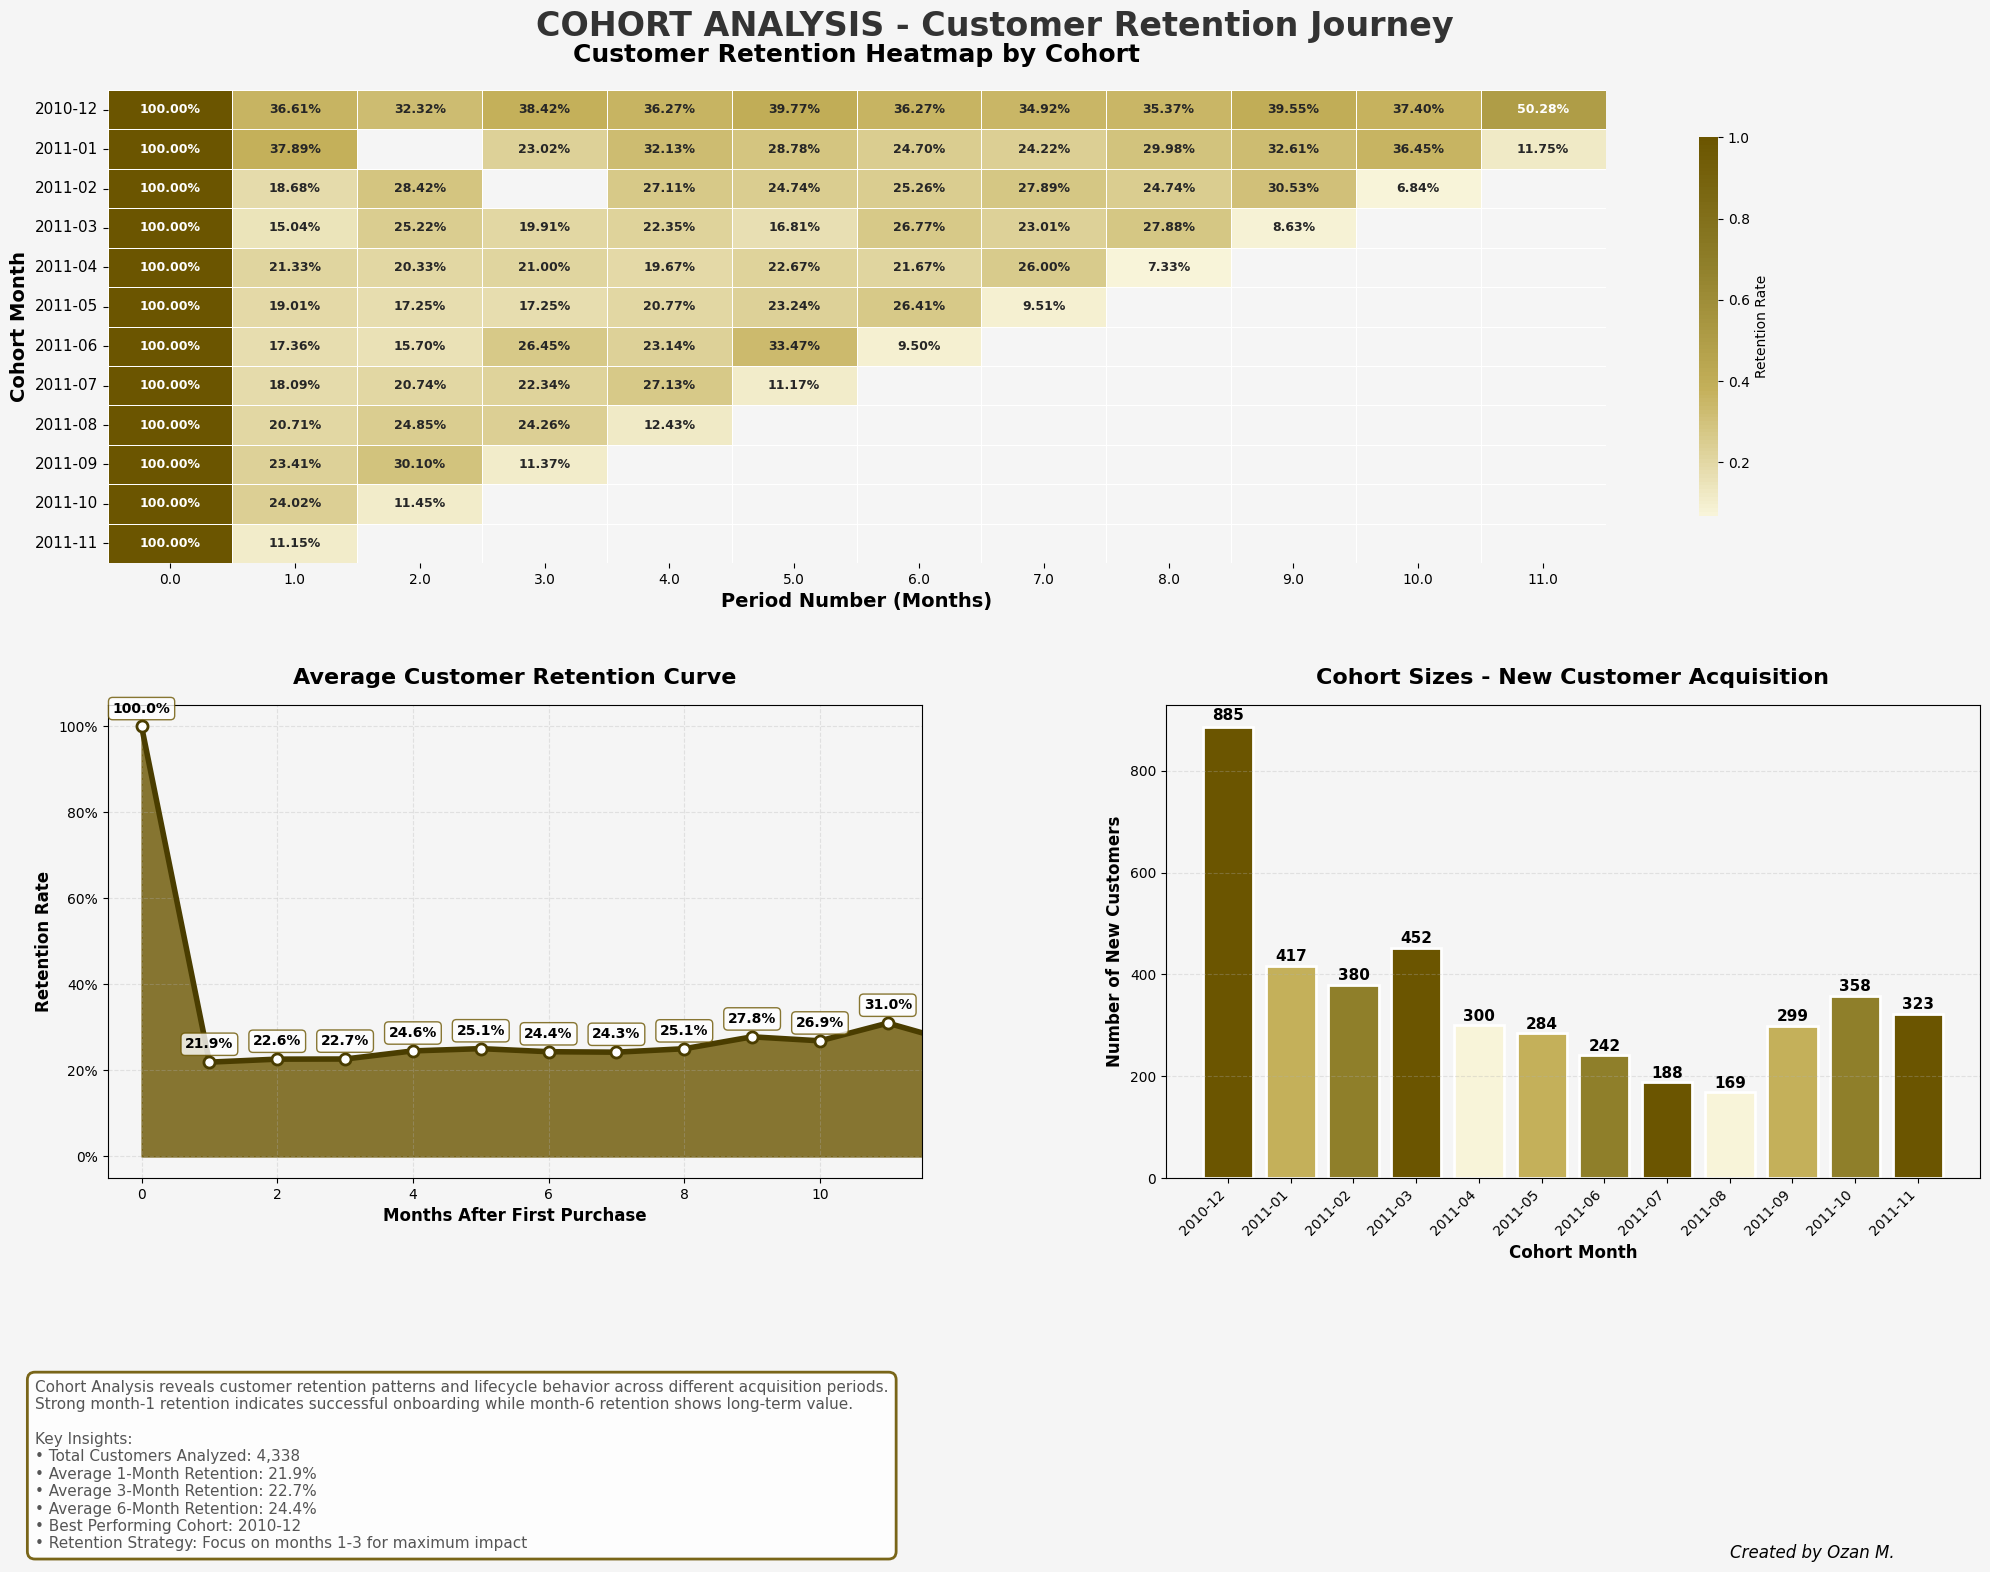

In [ ]:
colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']
gradient_colors = ['#6b5500', '#8f7f2a', '#c4b05a', '#f8f4d9', '#fff5cc']

df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df_positive = df[df['Quantity'] > 0].copy()


def get_month(x):
    """Tarihi yıl-ay formatına çevir"""
    if pd.isna(x):
        return pd.NaT
    return datetime(x.year, x.month, 1)

df_positive['OrderMonth'] = df_positive['InvoiceDate'].apply(get_month)
df_positive['InvoiceMonth'] = df_positive['InvoiceDate'].apply(get_month)


df_cohort = df_positive.groupby('CustomerID')['OrderMonth'].min().reset_index()
df_cohort.columns = ['CustomerID', 'CohortMonth']


df_positive = df_positive.merge(df_cohort, on='CustomerID')

def get_period_number(df):
    """Cohort ayından kaç ay sonra olduğunu hesapla"""
    df['PeriodNumber'] = (df['OrderMonth'] - df['CohortMonth']).dt.days // 30
    return df

df_positive = get_period_number(df_positive)


cohort_data = df_positive.groupby(['CohortMonth', 'PeriodNumber'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='PeriodNumber', values='CustomerID')


cohort_sizes = df_cohort.groupby('CohortMonth')['CustomerID'].nunique()


retention_rates = cohort_counts.divide(cohort_sizes, axis=0)


fig = plt.figure(figsize=(20, 16))
fig.suptitle('COHORT ANALYSIS - Customer Retention Journey', fontsize=24, fontweight='bold', y=0.98, color='#333')
fig.patch.set_facecolor('#f5f5f5')


ax1 = plt.subplot(2, 2, (1, 2))
ax1.set_facecolor('#f5f5f5')


from matplotlib.colors import LinearSegmentedColormap
custom_colors = ['#f8f4d9', '#c4b05a', '#8f7f2a', '#6b5500']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', custom_colors, N=n_bins)


sns.heatmap(retention_rates.iloc[:12, :12],
            annot=True,
            fmt='.2%',
            cmap=cmap,
            linewidths=0.5,
            linecolor='white',
            cbar_kws={'label': 'Retention Rate', 'shrink': 0.8},
            ax=ax1,
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})

ax1.set_title('Customer Retention Heatmap by Cohort', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Period Number (Months)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cohort Month', fontsize=14, fontweight='bold')


cohort_labels = [d.strftime('%Y-%m') for d in retention_rates.index[:12]]
ax1.set_yticklabels(cohort_labels, rotation=0, fontsize=11)


ax2 = plt.subplot(2, 2, 3)
ax2.set_facecolor('#f5f5f5')


avg_retention = retention_rates.mean()
periods = range(len(avg_retention))


ax2.fill_between(periods, avg_retention, alpha=0.8, color=colors[3])
ax2.plot(periods, avg_retention, color='#4a3d00', linewidth=4, marker='o',
         markersize=8, markerfacecolor='white', markeredgecolor='#4a3d00',
         markeredgewidth=2)


for i, rate in enumerate(avg_retention):
    if i < 12:  # İlk 12 ay
        ax2.annotate(f'{rate:.1%}', (i, rate), textcoords="offset points",
                    xytext=(0,10), ha='center', fontweight='bold', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                             edgecolor=colors[3], alpha=0.8))

ax2.set_title('Average Customer Retention Curve', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Months After First Purchase', fontsize=12, fontweight='bold')
ax2.set_ylabel('Retention Rate', fontsize=12, fontweight='bold')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y:.0%}'))
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(-0.5, 11.5)


ax3 = plt.subplot(2, 2, 4)
ax3.set_facecolor('#f5f5f5')


cohort_sizes_top12 = cohort_sizes.head(12)
bars = ax3.bar(range(len(cohort_sizes_top12)), cohort_sizes_top12.values,
               color=[colors[3] if i == 0 else colors[i % len(colors)] for i in range(len(cohort_sizes_top12))],
               edgecolor='white', linewidth=2)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax3.set_title('Cohort Sizes - New Customer Acquisition', fontsize=16, fontweight='bold', pad=15)
ax3.set_xlabel('Cohort Month', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of New Customers', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(cohort_sizes_top12)))
ax3.set_xticklabels([d.strftime('%Y-%m') for d in cohort_sizes_top12.index],
                    rotation=45, ha='right', fontsize=10)
ax3.grid(axis='y', alpha=0.3, linestyle='--')


total_customers = len(df_cohort)
avg_retention_month1 = retention_rates.iloc[:, 1].mean() if len(retention_rates.columns) > 1 else 0
avg_retention_month3 = retention_rates.iloc[:, 3].mean() if len(retention_rates.columns) > 3 else 0
avg_retention_month6 = retention_rates.iloc[:, 6].mean() if len(retention_rates.columns) > 6 else 0


best_cohort = retention_rates.iloc[:, 3].idxmax() if len(retention_rates.columns) > 3 else retention_rates.index[0]
worst_cohort = retention_rates.iloc[:, 3].idxmin() if len(retention_rates.columns) > 3 else retention_rates.index[0]


analysis_text = f"""Cohort Analysis reveals customer retention patterns and lifecycle behavior across different acquisition periods.
Strong month-1 retention indicates successful onboarding while month-6 retention shows long-term value.

Key Insights:
• Total Customers Analyzed: {total_customers:,}
• Average 1-Month Retention: {avg_retention_month1:.1%}
• Average 3-Month Retention: {avg_retention_month3:.1%}
• Average 6-Month Retention: {avg_retention_month6:.1%}
• Best Performing Cohort: {best_cohort.strftime('%Y-%m')}
• Retention Strategy: Focus on months 1-3 for maximum impact"""

plt.figtext(0.02, 0.02, analysis_text, fontsize=11, color='#555',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9,
                     edgecolor=colors[3], linewidth=2),
            wrap=True)


plt.figtext(0.95, 0.01, 'Created by Ozan M.', fontsize=12, color='#000000', style='italic',
            verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.25, hspace=0.3, wspace=0.3)
plt.show()


cohort_summary = pd.DataFrame({
    'CohortMonth': cohort_sizes.index,
    'CohortSize': cohort_sizes.values,
    'Month1_Retention': retention_rates.iloc[:, 1].values if len(retention_rates.columns) > 1 else np.nan,
    'Month3_Retention': retention_rates.iloc[:, 3].values if len(retention_rates.columns) > 3 else np.nan,
    'Month6_Retention': retention_rates.iloc[:, 6].values if len(retention_rates.columns) > 6 else np.nan
})


retention_insights = {
    'High Retention (>40%)': 'Exceptional - Study and replicate success factors',
    'Good Retention (20-40%)': 'Solid - Maintain current engagement strategies',
    'Average Retention (10-20%)': 'Needs improvement - Enhance onboarding',
    'Low Retention (<10%)': 'Critical - Immediate intervention required'
}